In [2]:
import numpy as np
from numpy.linalg import norm, solve

import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab20')

from spectral_help import *

In [3]:
# plot params
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Example Definition

In [4]:
class toy_data:
    """ 
    Generate toy oscillation data at specific frequencies.
    """
    def __init__(self, tf, npts, noise):
        """
        Parameters:
            tf: final time
            npts: number of samples between 0 and tf
            noise: standard deviation of additive Gaussian noise
        """
        self.tf = tf
        self.npts = npts
        self.ts = np.linspace(0, self.tf, self.npts)
        self.dt = self.ts[1] - self.ts[0]
        self.noise = noise
        
        # Manual toy data (a stack of sines)
        self.freqs = [0.5, 2, 0.75, 3]
        self.X_fn = lambda ts: np.vstack([(np.sin([2 * np.pi * self.freqs[0] * ts]) + np.sin([2 * np.pi * self.freqs[1] * ts])),
                                          (np.sin([2 * np.pi * self.freqs[2] * ts]) + np.sin([2 * np.pi * self.freqs[3] * ts]))])
        
        # Normalize, add noise
        X = self.X_fn(self.ts)
        self.X_mean = np.mean(X, axis=1).reshape(-1,1)
        self.X_std = np.std(X, axis=1).reshape(-1,1)
        X = (X - self.X_mean)/self.X_std
        self.X_true = np.copy(X)
        self.X = X + np.random.randn(*X.shape)*self.noise
        
        # Construct test vars
        self.ts_test = None
        self.X_test = None
        
        
    def run_test(self, tf_predict, npts_predict):
        """
        Parameters:
            tf_predict: final time
            npts_predict: number of points between 0 and tf_predict
            
        Updates:
            self.ts_test: test time series
            self.X_test_true: normalized ground truth for the test
        """
        self.ts_test = np.linspace(0, tf_predict, npts_predict)
        X_test = self.X_fn(self.ts_test)
        
        # Use training std_dev and mean
        self.X_test_true = (X_test - self.X_mean)/self.X_std 

# Example Configuration
We run the spectral dynamic mode decomposition algorithm to learn the frequencies of an operator generating our toy data. We can do this with very noisy data (we set the standard deviation at 0.5 for mean-zero variance-one toy training data).

First, we configure the model. Then we set up the algorithm. Finally, we run the optimization.

The optimization is performed using the Accelerated Proximal Gradient Descent Method, or AGPD. The reason is because we are imposing sparsity using a $\ell_1$ norm--that is, a LASSO-type optimization.

In [5]:
# Config
# ======
np.random.seed(1)

# Data params
npts = 400             # number of time points
tf = 8                 # max time
std_noise = .5         # set the amount of noise on the mean-0, variance-1 data
predict_factor = 3     # prediction goes out to factor*T
exper = toy_data(tf, npts, std_noise)

# Algorithm params
freq_dim = 24          # freq. for algo to try
learning_rate = 1e-3   # LR = 1/beta from beta-smooth obj. bound (at least ideally--I'm just choosing a number here)
reg_factor = 5         # regularization on sparsity

# SVD parameters 
threshold_type = 'percent' # choose 'count' for number or 'percent' for s/max(s) > threshold
threshold = 1e-1

# Plot toggle
print_omega_updates = True
def print_update(omg, title):
    if print_omega_updates:
        print('{} $\omega$:\t'.format(title), np.sort(np.round(omg[omg.astype(bool)], 3)))

In [6]:
# Algorithm
# =========
# 1. Initialize
omega = np.zeros(freq_dim)*2
print_update(omega, 'Initial')
A = np.random.rand(exper.X.shape[0], freq_dim*2)

obj_his = []
err_his = []

# 2. FFT to obtain the initial starting point for the optimization
for ifreq in range(len(omega)):
    # - Construct the residual via the current frequencies
    res = residual_j(ifreq, exper.X, A, omega, exper.ts)

    # - Select the maximum fft frequency as the initial value
    omega[ifreq] = max_fft_update(res, exper.dt)

    # - Update A
    A = update_A(exper.X, omega, exper.ts, threshold, threshold_type)

# 3. Perform proximal gradient descent from the initial point
# - Construct optimization functions
lam_cs = reg_factor*norm(A.T.dot(exper.X), np.inf)
def f(w):
    return loss(exper.X, A, w.flatten(), exper.ts)
def gradf(w):  
    return grad_loss(exper.X, A, w.flatten(), exper.ts)
def func_g(w):
    return lam_cs*np.linalg.norm(w, ord=1)
def prox_g(w, t):
    res = []
    r = t*lam_cs
    for wi in w.flatten():
        if wi > r:
            res.append(wi-r)
        elif wi < -r:
            res.append(wi+r)
        else:
            res.append(0)
    return np.array(res)

# - Optimization algorithm
w, iobj_his, ierr_his, cond = optimizeWithAPGD(omega.reshape(1,-1), f, func_g, gradf, prox_g, (1/learning_rate)*npts, max_iter=5000, verbose=True)
obj_his.append(iobj_his)
err_his.append(ierr_his)
omega = w
print_update(omega, 'Final  ')

# 4. Final operator update
A = update_A(exper.X, omega, exper.ts, threshold, threshold_type)
print_update(np.array(exper.freqs), 'Expected')

Initial $\omega$:	 []
Final   $\omega$:	 [0.494 0.743 1.991 2.99 ]
Expected $\omega$:	 [0.5  0.75 2.   3.  ]


We printed out the frequencies (previous cell). In the next cell, we show the objective value and the gradient of the objective for the iterations of the optimization. The characteristic oscillations of an accelerated gradient descent are observed.

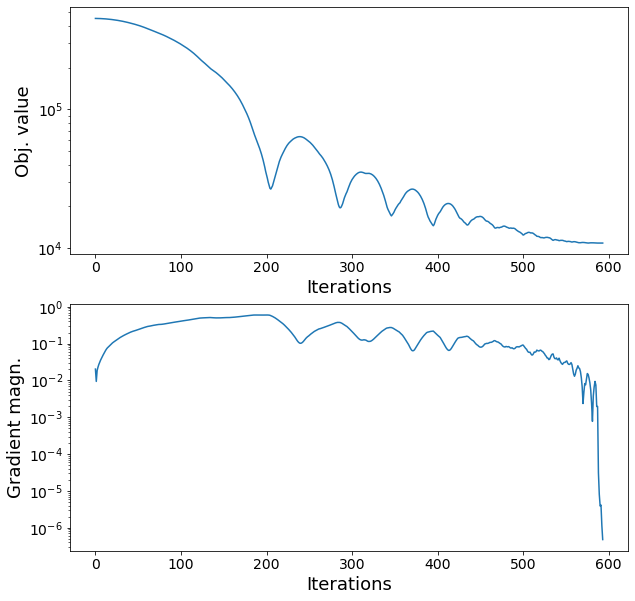

In [7]:
# Plot 
# ====
# Inspect convergence results
fig,axes = plt.subplots(2,1,figsize=[10,10])
ax = axes[0]
ax.plot(iobj_his)
ax.set_ylabel('Obj. value')
ax.set_xlabel('Iterations')
ax.set_yscale('log')
ax = axes[1]
ax.plot(ierr_his)
ax.set_ylabel('Gradient magn.')
ax.set_xlabel('Iterations')
ax.set_yscale('log')

# Result
We see the training (top) and test (bottom) results for our two-dimensional multi-frequency dynamics.

Notice the order of magnitude increase in the horizontal time axis on the bottom plot. On this plot, we observe that the solutions match the test simulations and are stable because of the model assumptions.

(-3.5, 3.5)

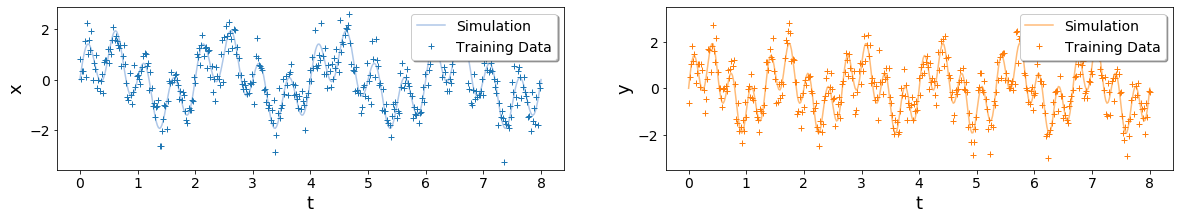

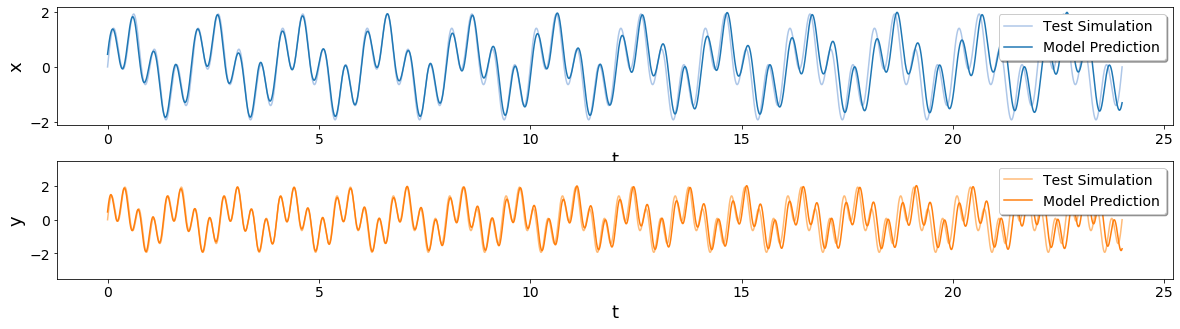

In [8]:
# Make prediction
exper.run_test(tf*predict_factor, 10*npts) # keep sample freq the same

bigOmg_test = BigOmg(omega, exper.ts_test)
X_pred = A@(bigOmg_test)


# Plot data
fig,axes = plt.subplots(1,2,figsize=[20,3])
fig.subplots_adjust(hspace=0.3, wspace=0.2)
leg_params = {'loc': 'upper right', 'shadow': True, 'fancybox': True}

ax = axes[0]
ax.plot(exper.ts, exper.X_true[0], color=cmap(1), label='Simulation')
ax.plot(exper.ts, exper.X[0], ls='', marker='+', color=cmap(0), label='Training Data')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(**leg_params)
ax = axes[1]
ax.plot(exper.ts, exper.X_true[1], color=cmap(3), label='Simulation')
ax.plot(exper.ts, exper.X[1], ls='', marker='+', color=cmap(2), label='Training Data')
ax.legend(**leg_params)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_ylim([-3.5,3.5])

# Plot model
fig,axes = plt.subplots(2,1,figsize=[20,5])
fig.subplots_adjust(hspace=0.3, wspace=0.2)
leg_params = {'loc': 'upper right', 'shadow': True, 'fancybox': True}

ax = axes[0]
ax.plot(exper.ts_test, exper.X_test_true[0], color=cmap(1), label='Test Simulation')
ax.plot(exper.ts_test, X_pred[0], ls='-', color=cmap(0), label='Model Prediction')
ax.legend(**leg_params)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax = axes[1]
ax.plot(exper.ts_test, exper.X_test_true[1], color=cmap(3), label='Test Simulation')
ax.plot(exper.ts_test, X_pred[1], ls='-', color=cmap(2), label='Model Prediction')
ax.legend(**leg_params)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_ylim([-3.5,3.5])